In [1]:
%load_ext autoreload
%autoreload 2

# load general packages
import numpy as np
import matplotlib.pyplot as plt

# load modules related to this exercise
import Exercise_6 as ex6
import tools as tools

# Exercise 6: Gaussian Shock

Consider the model
$$\begin{align*}
V_{t}(W_{t}) & = & \max_{C_{t}}\left\{ \frac{C_{t}^{1-\rho}}{1-\rho}+\beta\mathbb{E}_{t}\left[V_{t+1}(W_{t+1})\right]\right\} \\
 & \text{s.t.}\\
W_{t+1} & = & R(W_{t}-C_{t})+Y_{t+1}\\
Y_{t+1} & = & \exp(\xi_{t+1})\\
\xi_{t+1} & = & \mathcal{N}(0,\sigma_{\xi}^{2})\\
A_{t}=W_{t}-C_{t} & \geq & 0
\end{align*}$$

for $T=10$, $\beta=0.98$, $\rho=0.5$, $R=1.0/\beta$, $W_1=10$ and $\sigma_{\xi}=0.2$. Since $Y_{t+1} = \exp (\xi_{t+1})$ and $\xi_{t+1}\sim \mathcal{N}(0,\sigma^2_{\xi})$, we get $Y_{t+1}\sim \exp(\mathcal{N}(0,\sigma^2_{\xi}))$ with expected income being: $\mathbb{E}[Y_{t+1}]=\exp \left( \frac{\sigma^2_{\xi}}{2} \right)$

### 1. Solve it using Gauss-Hermite quadrature for evaluating the expectation. 

In [2]:
# setup class with model specifications
class par: pass
par.beta = 0.98
par.rho = 0.5
par.R = 1.0/par.beta
par.sigma = 0.2
par.mu = 0
par.W = 10
par.T = 10
par.num_shocks = 5

# Gauss-Hermite nodes and transformation
x,w = tools.gauss_hermite(par.num_shocks) # "raw nodes"
par.eps = np.exp(par.mu + par.sigma*np.sqrt(2)*x) # node change, see slides
par.eps_w = w/np.sqrt(np.pi) # weight change, like with normal r.v.

# Grid
par.num_W = 200
par.num_C = 200

# Solve the model
sol = ex6.solve_consumption_deaton(par)

### 2. Plot the consumption function and the value function. See how the optimal consumption and value function varies over time.

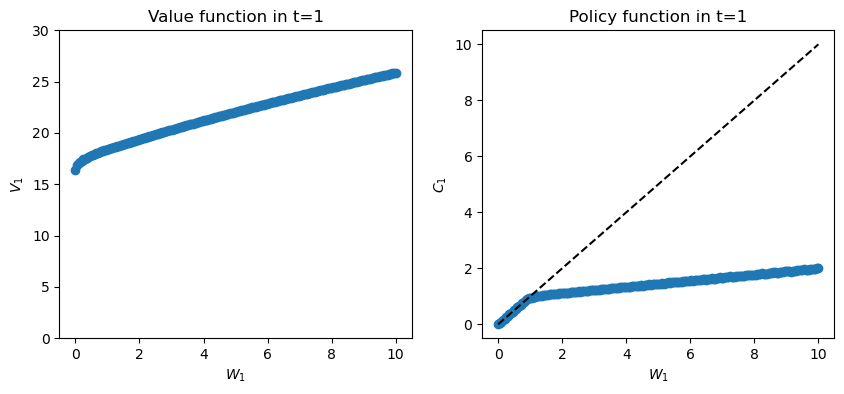

In [3]:
# define a function for the solution
def plot_solution(sol,t):

    f, ax = plt.subplots(1, 2, figsize=(10,4))# figsize is in inches...
    
    ax[0].set_title(f'Value function in t={t+1}')
    ax[0].scatter(sol.grid_W[:,t],sol.V[:,t])
    ax[0].set_xlabel(f"$W_{t+1}$")
    ax[0].set_ylabel(f"$V_{t+1}$")
    ax[0].set_ylim(0,30)

    ax[1].set_title(f'Policy function in t={t+1}')
    ax[1].scatter(sol.grid_W[:,t],sol.C[:,t])
    ax[1].plot(sol.grid_W[:,t],sol.grid_W[:,t],color='black',linestyle='dashed')
    ax[1].set_xlabel(f"$W_{t+1}$")
    ax[1].set_ylabel(f"$C_{t+1}$")

plot_solution(sol,0)

What do you attribute the kink in the policy function to?

### 3. Simulate a panel of *N* household for *T* periods and plot the mean of $C_t$. Everybody should be initialized with $W_t = 1.5$. Compare a simulation where $\sigma_{\xi}=0.2$ and $\sigma_{\xi}=0$. What happens to consumption over time in the two simulations?

In [4]:
# setup
par.simN = 10000
par.W_ini = 1.5

# create a copy of the class
class par_sigma_0(par): pass  

par_sigma_0.sigma = 0 # easy way of using framework in Exercise_6.py
x,w = tools.gauss_hermite(par_sigma_0.num_shocks)
par_sigma_0.eps = np.exp(par_sigma_0.sigma*np.sqrt(2)*x)
par_sigma_0.eps_w = w/np.sqrt(np.pi)

In [5]:
np.random.seed(2026) #Seed value, it ensures that the computer draw the same pseudo-random-numbers each time

def simulate(sol, par):

    # 1. allocate memory and sim
    class sim: pass
    sim.W = np.zeros((par.simN, par.T)) + np.nan
    sim.C = np.zeros((par.simN, par.T)) + np.nan

    # 2. simulate
    sim.W[:, 0] = par.W_ini
    
    for t in range(par.T):
        
        # FILL IN. Hint: almost identical to exercise 4, question 5

        ### SOLUTION ###
        sim.C[:, t] = np.interp(sim.W[:, t], sol.grid_W[:, t], sol.C[:, t]) # interpolate policy
        eps = np.exp(np.random.normal(0, scale=par.sigma, size=par.simN)) # draw shocks
        if t < par.T-1: # state transition
            sim.W[:, t+1] = par.R*(sim.W[:, t] - sim.C[:, t]) + eps 
        ### SOLUTION ###
    
    return sim

In [6]:
# Simulation for sigma=0
sol_sigma_0 = ex6.solve_consumption_deaton(par_sigma_0)
sim_sigma_0 = simulate(sol_sigma_0,par_sigma_0)
sim_C_sigma_0 = np.mean(sim_sigma_0.C, axis=0) # mean over cross-sectional dimension
sim_W_sigma_0 = np.mean(sim_sigma_0.W, axis=0) # mean over cross-sectional dimension

# Simulation for sigma=0.2
sim = simulate(sol,par)
sim_C = np.mean(sim.C, axis=0) # mean over cross-sectional dimension
sim_W = np.mean(sim.W, axis=0) # mean over cross-sectional dimension

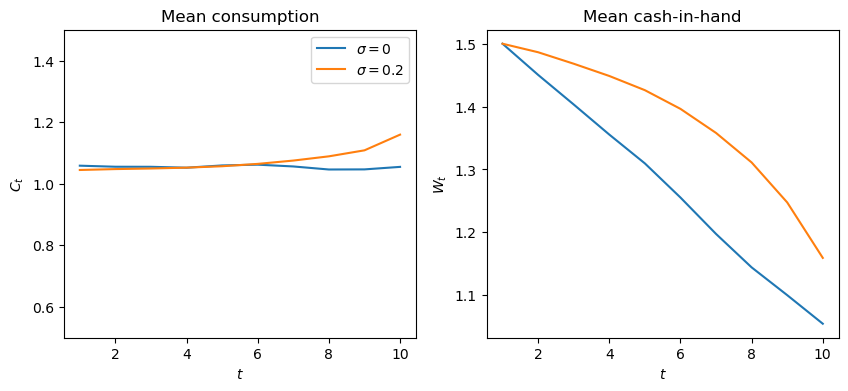

In [7]:
f, ax = plt.subplots(1, 2, figsize=(10,4))
    
ax[0].plot(range(1,par_sigma_0.T+1),sim_C_sigma_0, label=r'$\sigma = 0$')
ax[0].plot(range(1,par.T+1),sim_C, label=r'$\sigma = 0.2$')
ax[0].set_ylabel('$C_t$')
ax[0].set_xlabel('$t$')
ax[0].set_title('Mean consumption')
ax[0].set_ylim(0.5,1.5)
ax[0].legend()

ax[1].plot(range(1,par_sigma_0.T+1),sim_W_sigma_0, label=r'$\sigma = 0$')
ax[1].plot(range(1,par.T+1),sim_W, label=r'$\sigma = 0.2$')
ax[1].set_ylabel('$W_t$')
ax[1].set_xlabel('$t$')
ax[1].set_title('Mean cash-in-hand');

### 4. Calculate the Euler-error 
The Euler-equation with uncertainty is given by
$$\begin{align*}
  u'(C_{i,t}) = \beta R \mathbb{E}_t[u'(C_{i,t+1})]
\end{align*}$$

The Euler-error is computed as
$$\begin{align*}
  \varepsilon_{it} \approx u'(C_{it})-\beta R \sum_{j=1}^{S} \omega_j \Big[u'\big(C_{i,t+1}^{\star}(R(W_{it}-C_{it})+Y_j)\big)\Big]
 \end{align*}$$
 and $\omega_j$ are the Gauss-Hermite weights and $Y_j$ are the associated income nodes.

The mean Euler-error is given by
$$\begin{align*}
 \frac{1}{\sum_{i=1}^{N}\sum_{t=1}^{T-1}  \mathbb{1}_{\{0<C_{it}<W_{it}\}}}\sum_{i=1}^{N}\sum_{t=1}^{T} \mathbb{1}_{\{0<C_{it}<W_{it}\}} |\varepsilon_{it}|
 \end{align*}$$
where it must hold that $0<C_{it}<W_{it}$. If $C_{it}=W_{it}$, agents are credit constrained and the Euler equation doesn't hold.

In [8]:
# define the marginal utility
def marg_util(par, C):
    return C**(-par.rho)

In [9]:
# 1. solve the model
sol = ex6.solve_consumption_deaton(par)

# 2. simulate
sim = simulate(sol,par)

# 3. calculate the Euler residual
Euler_residual = np.zeros((par.simN,par.T-1)) + np.nan # allocate memory
A = np.zeros((par.simN,par.T-1)) + np.nan # allocate memory

for t in range(par.T-1):   # Sum over t (and the sum over N happens in vector notation)
    
    # Initialize
    w = sim.W[:,t]
    c = sim.C[:,t]
    w_c = w-c
    A[:,t] = w_c 
    
    marg_util_next = 0

    for s in range(par.num_shocks):
                    
                    # FILL IN. Hint: Calculate expectations within the loop

                    ### SOLUTION ###
                    eps_i = par.eps[s]
                    eps_w_i = par.eps_w[s]
                    w_c_i = w_c + eps_i # implied next-period cash-on-hand
                    c_next_i = np.interp(w_c_i, sol.grid_W[:, t+1], sol.C[:, t+1]) # interpolate next period policy
                    marg_util_next += eps_w_i*marg_util(par, c_next_i) # add weighted marginal utility
                    ### SOLUTION ###
                    
    Euler_residual[:,t] = marg_util(par, c)-par.beta*par.R*marg_util_next

# 4. Calculate the average absolute euler residual
Euler_error = np.mean(abs(Euler_residual[(A>0)])) # slice only to only consider interior residuals

print(f'The Euler error:    {Euler_error:.4f}')

The Euler error:    0.0028


### 5. Likewise calculate the normalized Euler-error


$$\begin{align*}
 \frac{1}{\sum_{i=1}^{N}\sum_{t=1}^{T} \mathbb{1}_{\{0<C_1<W_{it}\}}}\sum_{i=1}^{N}\sum_{t=1}^{T} log_{10}(|\varepsilon_{it}| / C_{it}) \mathbb{1}_{0<C_1<W_{it}} 
 \end{align*}$$

and discuss what this implies for the accuracy of the solution.

In [10]:
C =(sim.C[:,0:par.T-1])  # The euler error is not defined in last period

nom_Euler_error = np.log10(abs(Euler_residual[(A>0)])/(C[(A>0)]))   
nom_Euler_error = np.mean(nom_Euler_error)

print(f'The Normalized Euler error:    {nom_Euler_error:.4f}')

The Normalized Euler error:    -2.9050


### 6. Look at how the Euler-errors change when you vary the number of grid points. 

In [11]:
#Function for Setup
def setup():
    class par: pass
    par.beta = 0.98
    par.rho = 0.5
    par.R = 1.0/par.beta
    par.sigma = 0.2
    par.mu = 0
    par.W = 50
    par.T = 10
    
    par.num_shocks = 5
    x,w = tools.gauss_hermite(par.num_shocks)
    par.eps = np.exp(par.sigma*np.sqrt(2)*x)
    par.eps_w = w/np.sqrt(np.pi)
    
    # Grid
    par.num_W = 200
    par.num_C = 200

    # Simulation parameters
    par.simN = 10000
    par.W_ini = 1.5
    
    return par

def Euler_error(par, sol, sim):
    Euler_residual = np.nan + np.zeros((par.simN,par.T-1))  # Allocate space
    A = np.nan + np.zeros((par.simN,par.T-1))               # Allocate space
    
    for t in range(par.T-1):   # Sum over t (and the sum over N happens in vector notation)
        
        # Initialize
        w = sim.W[:,t]
        c = sim.C[:,t]
        w_c = w-c
        A[:,t] = w_c 
        
        marg_util_next = 0
    
        for s in range(par.num_shocks):
                        
                        # FILL IN. Hint: What you did earlier

                        ### SOLUTION ###
                        eps_i = par.eps[s]
                        eps_w_i = par.eps_w[s]
                        w_c_i = par.R*w_c + eps_i
                        c_next_i = np.interp(w_c_i, sol.grid_W[:, t+1], sol.C[:, t+1])
                        marg_util_next += eps_w_i*marg_util(par, c_next_i)
                        ### SOLUTION ###
                        
        Euler_residual[:,t] = marg_util(par,c)-par.beta*par.R*marg_util_next

    Euler_error = np.mean(abs(Euler_residual[(A>0)]))
    
    C =(sim.C[:,0:par.T-1])

    nom_Euler_error = np.log10(abs(Euler_residual[(A>0)])/(C[(A>0)]))   
    nom_Euler_error = np.mean(nom_Euler_error)
    
    print(f'Number of grid points:         {par.num_W} ')
    print(f'The Euler error:               {Euler_error:.4f}')
    print(f'The Normalized Euler error:    {nom_Euler_error:.4f}', end ='\n\n')

In [12]:
# array of grid points    
grid_points = np.array([10,20,40,50,70,100,1000])

for i,grid_point in enumerate(grid_points):

    # setup
    
    pars = setup()
    pars.num_W = grid_point
    
    # solve
    sols = ex6.solve_consumption_deaton(pars)

    # simulate
    sims = simulate(sol, pars)

    # calculate the errors
    Euler_error(pars, sols, sims)

Number of grid points:         10 
The Euler error:               1.0510
The Normalized Euler error:    -0.2174

Number of grid points:         20 
The Euler error:               0.5428
The Normalized Euler error:    -0.4751

Number of grid points:         40 
The Euler error:               0.1976
The Normalized Euler error:    -0.8802

Number of grid points:         50 
The Euler error:               0.1251
The Normalized Euler error:    -1.0623

Number of grid points:         70 
The Euler error:               0.0574
The Normalized Euler error:    -1.3683

Number of grid points:         100 
The Euler error:               0.0245
The Normalized Euler error:    -1.7327

Number of grid points:         1000 
The Euler error:               0.0026
The Normalized Euler error:    -2.8651

